In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm
import matplotlib.patches as mpatches
from sklearn.cluster import DBSCAN
import scipy
import re

import eye_metrics_utils
import data_utils
import gaze_entropy
import anova

In [2]:
import glob
csv_files = glob.glob("data/*.csv")
csv_files_two = [v for v in csv_files if "Two Gaze-Vergence" in v]

In [3]:
img = cv2.imread("flight.jpg")

overlay = img.copy()
thickness = -1

h,w,c = img.shape

In [4]:
roi_center = {
                "runway": (850, 170), 
                "rpmleft": (652, 438),
                "asi": (695, 490), 
                "alt": (820, 490),
                "nrst": (840, 550),
                "rpmright": (1050, 438),
             }

In [5]:
# modified ROIs
label = {"runway": [(0,0), (1280, 350), "r"],
         "rpmleft": [(633, 411), (672, 451), "r"],
         "asi": [(674, 432), (705, 525), "r"],
         "alt": [(797, 428), (852, 523), "r"],
         "hsi": [(742, 556), 45, "c"],
         "nrst": [(792, 534), (876, 554), "r"],
#          "RPM_RIGHT": [(1054, 440), 30, "c"]
}

encode_table = {
    "rpmleft": "P",
    "nrst": "Q",
#     "RPM_RIGHT": "R",
    "asi": "B",
    "hsi": "D",
    "alt": "E",
    "runway": "X",
    "unknown": "Z"
}

In [6]:
pdict = defaultdict()
for key in label:
    if label[key][-1] == "c":
        mask = np.zeros((h,w), np.uint8)
        cv2.circle(mask,label[key][0], label[key][1],255,-1)
        points = np.where(mask==255)
        pdict[key] = points
    elif label[key][-1] == "r":
        mask = np.zeros((h,w), np.uint8)
        cv2.rectangle(mask,label[key][0], label[key][1],255,-1)
        points = np.where(mask==255)
        pdict[key] = points

In [7]:
def distance(x, y):
    return ((x[0]-y[0])**2 + (x[1] - y[1])**2)**0.5

In [8]:
def calibration(df_fix, roi_center):
    diffx = []
    diffy = []
    idxmin= []
    for i in range(len(df_fix)):
        x = df_fix.iloc[i]
        m = np.argmin(x[-6:])
        idxmin.append(m)
        mx = list(roi_center.values())[m][0]
        my = list(roi_center.values())[m][1]

        if m == 0:
            w = 0.3
        else:
            w = 1
        diffx.append(w * (x.x - mx))
        diffy.append(w * (x.y - my))
    offsetx = np.mean(diffx)
    offsety = np.mean(diffy)
    print("offsetx", offsetx)
    print("offsety", offsety)
    
    return offsetx, offsety

In [9]:
def merge_consecutive_fixations_in_same_roi(df_fix):
    df_fix['value_grp'] = (df_fix.roi != df_fix.roi.shift()).cumsum()

    return pd.DataFrame({ 'start' : df_fix.groupby('value_grp').start.first(), 
                          'end' : df_fix.groupby('value_grp').end.last(),
                          'duration' : df_fix.groupby('value_grp').duration.sum(), 
                          'x' : df_fix.groupby('value_grp').x.mean(),
                          'y': df_fix.groupby('value_grp').y.mean(),
                          'roi': df_fix.groupby('value_grp').roi.first()
                         }).reset_index(drop=True)

In [10]:
def get_center(clustering, data):
    center = []
    for i in range(len(set(clustering.labels_)) - 1):
        xi = data[np.where(clustering.labels_ == i)]
        cx = sum(xi.T[0])/len(xi)
        cy = sum(xi.T[1])/len(xi)
        center.append((cx,cy))
    return center

In [11]:
def dist_func(point, v1, v2, type="c"): #between points and rectange/cirle
    """
    point: x, y
    v1,v2: topleft,bottomright if type = "r"
    v1,v2: center (x,y),  if type = "c"
    """    
    d = 0
    if type == "r":
        dx = max(v1[0] - point[0], 0, point[0] - v2[0])
        dy = max(v1[1] - point[1], 0, point[1] - v2[1])
        
        d = np.sqrt(dx*dx + dy*dy)
    elif type == "c":
        d = np.sqrt((point[0]-v1[0])**2 + (point[1]-v1[1])**2) - v2
        
    return d

In [12]:
def encode(lst_transition):
    str_transition = ""
    for v in lst_transition:
        str_transition = str_transition + encode_table[v]
    return str_transition

def decode(str_transition):
    lst_transition = []
    for v in str_transition:
        key_index = list(encode_table.values()).index(v)
        lst_transition.append(list(encode_table.keys())[key_index])
    return lst_transition

In [29]:
def run_one_data(filename):
    print(filename)
    df_data = pd.read_csv(filename)

    df_data = data_utils.reset_time(df_data)
    null_percent = data_utils.check_percentage_null(df_data)
    if null_percent > 0.2:
        print("null percent: {}, exclude ID {}".format(null_percent, filename[14:17]))
        return 0

    df_fixation = eye_metrics_utils.detect_fixations(df_data)
    df_blink = eye_metrics_utils.detect_blinks(df_data)
    df_saccade = eye_metrics_utils.detect_saccades(df_data)

    X = df_fixation[["x", "y"]].values
    clustering = DBSCAN(eps=20, min_samples=5, metric = distance).fit(X)
    df_fixation["roi"] = clustering.labels_
    df_fixation = merge_consecutive_fixations_in_same_roi(df_fixation)

    for k,v in roi_center.items():
        df_fixation["{}".format(k)] = df_fixation.apply(lambda x: distance(x[["x","y"]], v), axis=1)
        
        
    X = df_fixation[["x", "y"]].values
    clustering = DBSCAN(eps=20, min_samples=5, metric = distance).fit(X)

    color = clustering.labels_
    df_fixation["roi"] = clustering.labels_
        
#     img = plt.imread("flight.jpg")
#     h,w,c = img.shape
#     fig=plt.figure(figsize=(15,8))
#     ax=fig.add_axes([0,0,1,1])
#     # ax.imshow(img, extent=[0, 1600, 0, 900])
#     ax.imshow(img)
# #     ax.scatter(cluster_center[0], cluster_center[1], s=30, marker = "x", c = "red")
#     ax.scatter(X.T[0],X.T[1], c=color, cmap="jet", alpha = 0.5)

#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_title('center')

    offsetx, offsety = calibration(df_fixation, roi_center)
    df_fixation["x"] = df_fixation.x - offsetx
    df_fixation["y"] = df_fixation.y - offsety
    
    return df_fixation

In [25]:
def get_fixation_sequences(df_fixation, label = label, threshold = 20):
    roi = []
    count = 0
    for i in range(len(df_fixation)):
        x = df_fixation.iloc[i]
        point = (x.x, x.y)
        d = [dist_func(point, v[0], v[1], v[2]) for k,v in label.items()]
        order = np.argsort(d)
        if 0.0 not in d: # point is outside ROI
            if d[order[0]] > threshold:
                key = "unknown"
            else:
                key = list(pdict.keys())[order[0]]
        else:# point falls inside a ROI
            count += 1
            key = list(pdict.keys())[order[0]]
    #     print(d, order, key)
        roi.append(key)
    return roi

In [26]:
def create_transition_matrix(transitions):
    m = pd.crosstab(pd.Series(list(transitions)[1:], name = "t+1"),
            pd.Series(list(transitions)[:-1], name = "t"),normalize=1)
        
    return m

In [38]:
def create_transition_count_matrix(transitions):
    m = pd.crosstab(pd.Series(list(transitions)[1:], name = "t+1"),
            pd.Series(list(transitions)[:-1], name = "t"))
        
    return m

In [220]:
print(create_transition_matrix(transitions))
print(create_transition_count_matrix(transitions))

t             alt       asi  hsi      nrst   rpmleft    runway  unknown
t+1                                                                    
alt      0.000000  0.209302  0.5  0.166667  0.076923  0.396226      0.0
asi      0.272727  0.000000  0.0  0.000000  0.384615  0.528302      0.5
hsi      0.000000  0.000000  0.0  0.000000  0.000000  0.037736      0.0
nrst     0.121212  0.000000  0.0  0.000000  0.076923  0.018868      0.0
rpmleft  0.060606  0.209302  0.0  0.166667  0.000000  0.018868      0.0
runway   0.545455  0.558140  0.5  0.500000  0.461538  0.000000      0.5
unknown  0.000000  0.023256  0.0  0.166667  0.000000  0.000000      0.0
t        alt  asi  hsi  nrst  rpmleft  runway  unknown
t+1                                                   
alt        0    9    1     1        1      21        0
asi        9    0    0     0        5      28        1
hsi        0    0    0     0        0       2        0
nrst       4    0    0     0        1       1        0
rpmleft    2    9    0

In [288]:
def encode_transition(transitions, label_type = "random"):
    """
    assign a random letter for each roi
    """
    letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    L = list(set(transitions))
    print(L)
    enc_transitions = ""
    for roi in transitions:
        enc_transitions += letters[L.index(roi)]
        
    return enc_transitions, L

def decode_transitions(enc_transitions, list_labels):
    letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    dec_transitions = []
    for enc_t in enc_transitions:
        dec_transitions.append(list_labels[letters.index(enc_t)])
        
    return dec_transitions

In [302]:
def find_all(p, s):
    '''Yields all the positions of
    the pattern p in the string s.'''
    i = s.find(p)
    while i != -1:
        yield i
        i = s.find(p, i+1)
        
list(find_all("BB", "BBBABBABBB"))

[0, 1, 4, 7, 8]

In [357]:
def find_index_of_most_subseq(enc_transition, L):
    '''
    enc_transitions: encoded transitions
    '''
    length = 2
    subseqcount = defaultdict(int)

    for i in range(len(enc_transitions)-length + 1):
        substring = enc_transitions[i:i+length]
        subseqcount[substring] += 1
    max_subseq = max(subseqcount, key=subseqcount.get)
    max5 = {k:subseqcount.get(k) for k in sorted(subseqcount, key=subseqcount.get, reverse=True)[:5]}
    print("max 5 subseq:", max5)
    print("max_subseq:", max_subseq)
    print("max_subseq decode:", decode_transitions(max_subseq, L))
    list_idx_max_subseq = list(find_all(max_subseq, enc_transitions))
    
    return list_idx_max_subseq

In [337]:
def merge_2roi_to_1roi(df_data, list_idx):
    for idx in list_idx:
        df_x = df_data.loc[idx:idx + 1]
        start = df_x.iloc[0]["start"]
        end = df_x.iloc[1]["end"]
        duration = end - start
        x = df_x.iloc[0]["x"]
        y = df_x.iloc[0]["y"]
        roi = "{}_{}".format(df_x.iloc[0]['roi'], df_x.iloc[1]['roi'])
        
        df_data.loc[idx] = start, end, duration, x, y, roi
        if idx + 1 not in list_idx:
            df_data = df_data.drop(idx + 1)
        
    return df_data.reset_index(drop=True)

In [397]:
df_fixation = run_one_data(csv_files_two[2])
roi = get_fixation_sequences(df_fixation)
df_fixation["roi"] = roi
df_fixation = merge_consecutive_fixations_in_same_roi(df_fixation)
transitions = df_fixation["roi"]

data\PISSS_ID_003_Approach Two Gaze-Vergence.csv
offsetx 17.647147803731563
offsety -1.4763019074890766


In [398]:
level = 0
num_max_subseq = 100
list_df_transition_merged = []
list_transitions = []
df_transition_merged = df_fixation.copy()
list_df_transition_merged.append(df_transition_merged)

while num_max_subseq > 3:
    print("level:",level)
    enc_transitions, L = encode_transition(transitions)
    print("enc_transitions:", enc_transitions)
    list_idx_max_subseq = find_index_of_most_subseq(enc_transitions, L)
    print(list_idx_max_subseq)
    num_max_subseq = len(list_idx_max_subseq)
    print("num_max_subseq:",num_max_subseq)
    df_transition_merged = merge_2roi_to_1roi(df_transition_merged, list_idx_max_subseq)
    list_df_transition_merged.append(df_transition_merged)
    transitions = df_transition_merged["roi"]
    list_transitions.append(transitions)
    level += 1
    print("------------------------------------------------------------")

level: 0
['rpmleft', 'asi', 'unknown', 'alt', 'runway']
enc_transitions: AEBAECDEAEABAEBDECDEDEDEDEAEAEDBEBEBEBEBABEBEBEBEDEDEDECBEAEDEDEDEDEDEDEBEBAE
max 5 subseq: {'DE': 15, 'ED': 13, 'EB': 11, 'BE': 10, 'AE': 8}
max_subseq: DE
max_subseq decode: ['alt', 'runway']
[6, 15, 18, 20, 22, 24, 49, 51, 53, 60, 62, 64, 66, 68, 70]
num_max_subseq: 15
------------------------------------------------------------
level: 1
['alt_runway', 'rpmleft', 'asi', 'unknown', 'alt', 'runway']
enc_transitions: BFCBFDABFBCBFCADAAAABFBFECFCFCFCFCBCFCFCFCFAAADCFBFAAAAAACFCBF
max 5 subseq: {'FC': 10, 'AA': 10, 'CF': 10, 'BF': 8, 'CB': 4}
max_subseq: FC
max_subseq decode: ['runway', 'asi']
[1, 12, 26, 28, 30, 32, 36, 38, 40, 58]
num_max_subseq: 10
------------------------------------------------------------
level: 2
['alt_runway', 'rpmleft', 'runway_asi', 'asi', 'unknown', 'alt', 'runway']
enc_transitions: BCBGEABGBDBCAEAAAABGBGFDCCCCBDCCCGAAAEDGBGAAAAAADCBG
max 5 subseq: {'AA': 10, 'BG': 6, 'CC': 5, 'CB': 3, 'G

In [399]:
def construct_rect_signal(start, end, signal_end):
    signal = np.zeros(int(signal_end*1000), dtype=int)
    for i, s in enumerate(start):
        s = int(start[i]*1000)
        e = int(end[i]*1000)
        signal[s:e] = 1
        
    return signal


def create_rect_signal_from_transitions(df_transition):
    list_signals = {}
    signal_end = list(df_transition["end"])[-1]
    for roi in list(set(df_transition["roi"])):
        df_x = df_transition[df_transition["roi"] == roi]
        start = df_x['start'].values
        end = df_x['end'].values
        signal = construct_rect_signal(start, end, signal_end)
        list_signals[roi] = signal
        
    return list_signals

In [400]:
rect_signals = create_rect_signal_from_transitions(list_df_transition_merged[0])

In [401]:
rect_signals

{'alt_runway': array([0, 0, 0, ..., 0, 0, 0]),
 'rpmleft': array([1, 1, 1, ..., 0, 0, 0]),
 'asi': array([0, 0, 0, ..., 0, 0, 0]),
 'unknown': array([0, 0, 0, ..., 0, 0, 0]),
 'alt': array([0, 0, 0, ..., 0, 0, 0]),
 'runway': array([0, 0, 0, ..., 1, 1, 1])}

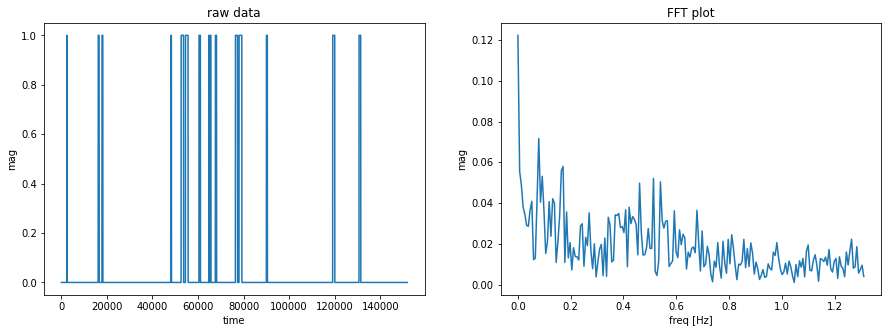

(array([ 1.22283110e-01-8.51160261e-19j, -5.26201995e-02-1.76792454e-02j,
         2.47140683e-02+4.20427749e-02j, ...,
        -2.49650836e-05+1.84835653e-05j,  9.03325899e-06-1.48641146e-05j,
        -2.12603126e-05-6.78518538e-06j]),
 array([0.00000000e+00, 6.58640040e-03, 1.31728008e-02, ...,
        4.99980241e+02, 4.99986827e+02, 4.99993414e+02]))

In [424]:
import scipy.fftpack
import matplotlib.pyplot as plt

signal = rect_signals["asi"]

def fftPlot(sig, dt=None, plot=True):
    # Here it's assumes analytic signal (real signal...) - so only half of the axis is required

    if dt is None:
        dt = 1
        t = np.arange(0, sig.shape[-1])
        xLabel = 'samples'
    else:
        t = np.arange(0, sig.shape[-1]) * dt
        xLabel = 'freq [Hz]'

    if sig.shape[0] % 2 != 0:
#         warnings.warn("signal preferred to be even in size, autoFixing it...")
        t = t[0:-1]
        sig = sig[0:-1]

    sigFFT = np.fft.fft(sig) / t.shape[0]  # Divided by size t for coherent magnitude

    freq = np.fft.fftfreq(t.shape[0], d=dt)

    # Plot analytic signal - right half of frequence axis needed only...
    firstNegInd = np.argmax(freq < 0)
    freqAxisPos = freq[0:firstNegInd]
    sigFFTPos = 2 * sigFFT[0:firstNegInd]  # *2 because of magnitude of analytic signal

    if plot:
        fix, ax = plt.subplots(ncols=2, figsize = (15,5))
        ax[0].plot(signal)
        ax[0].set_xlabel("time")
        ax[0].set_ylabel('mag')
        ax[0].set_title('raw data')
        
        ax[1].plot(freqAxisPos[:200], np.abs(sigFFTPos)[:200])
        ax[1].set_xlabel(xLabel)
        ax[1].set_ylabel('mag')
        ax[1].set_title('FFT plot')
        plt.show()

    return sigFFTPos, freqAxisPos

dt = 1 / 1000
fftPlot(signal, dt=dt)
# Result in samples (if the frequencies axis is unknown)
# fftPlot(signal)

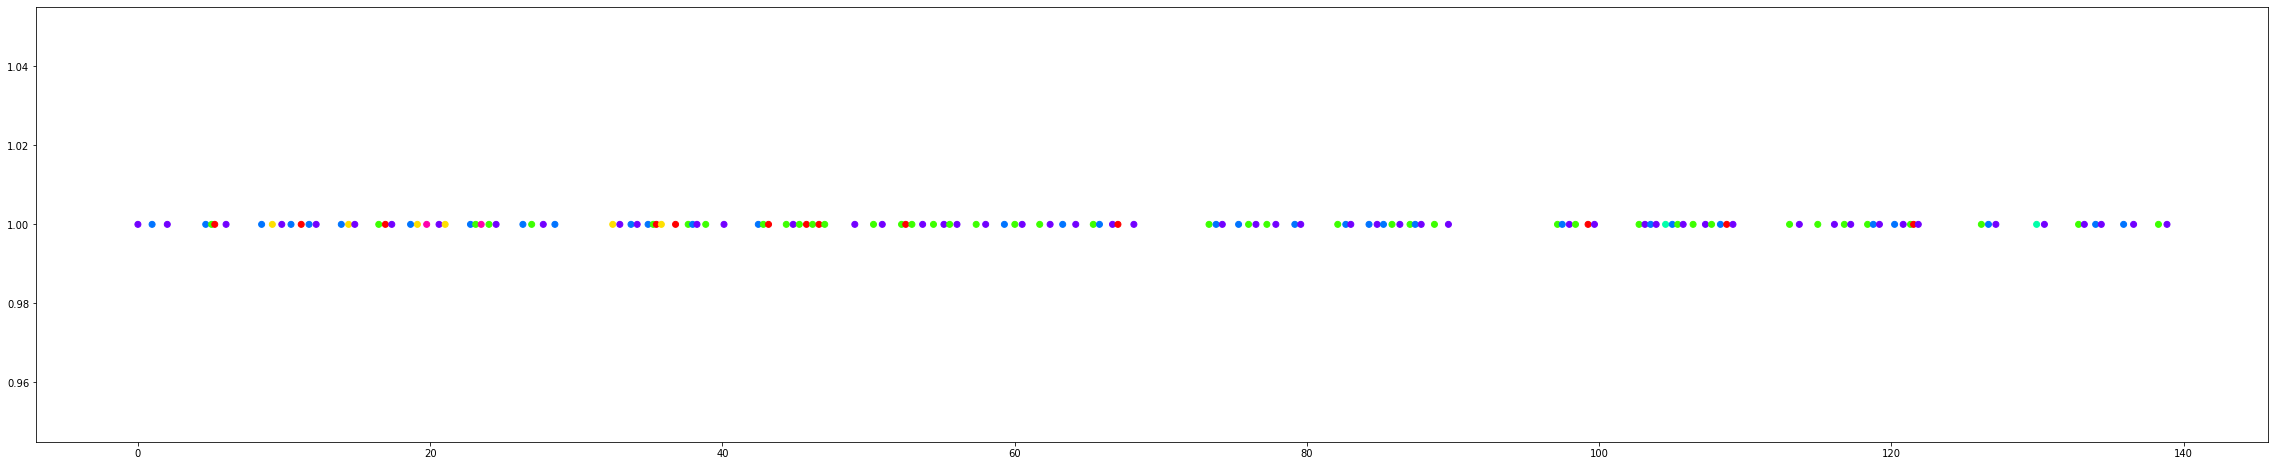

In [62]:
# colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 6))
colors = plt.get_cmap('hsv')(np.linspace(0, 0.9, 7))

color_codes = {
    "rpmleft": colors[0],
    "nrst": colors[1],
    "asi": colors[2],
    "hsi": colors[3],
    "alt": colors[4],
    "runway": colors[5],
    "unknown": colors[6],
}

# equal width
fig, ax = plt.subplots(figsize=(40, 8))
x = df_fixation["start"]
y = [1] * len(x)
cols = [color_codes[v] for v in df_fixation['roi']]
ax.scatter(x, y, c=cols)
